**DeepWalk**

DeepWalk란 Skip-Gram과 Random Walk 알고리즘의 결합으로 이해할 수 있다.

우선, Skip-Gram부터 알아보도록 하자.

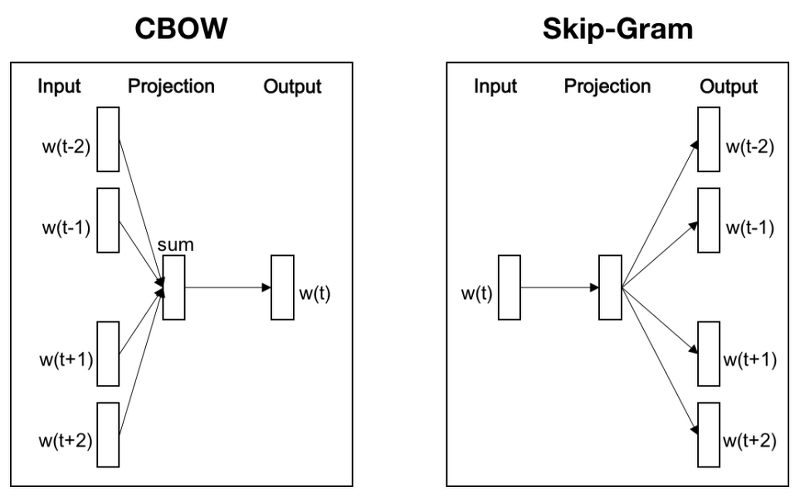

Skip-Gram은 비슷한 의미를 가지는 단어들은 대체로 문장에서 인접한 위치를 가진다는 점에서 착안하여 고안된 알고리즘이다. 특정 단어 w(t)가 주어졌을 때 인접한 단어들이 나올 확률을 높이는 방식으로 차원 축소(embedding) 하게 된다. 이를 통해, 문장에서 단어가 주어졌을 때 다른 단어들을 예측할 수 있게 된다. Skip-Gram을 Graph에 이용하기 위해 등장한 기법이 Random Walk이다. Graph를 문장 구조와 비슷한 형태로 변환시키는 것이다. 아래의 그래프를 살펴보자. 

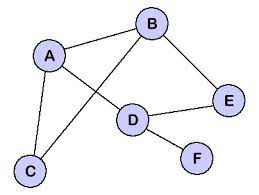

Random Walk를 진행하면 Root Node로 부터 시작하여 랜덤하게 adjacent한 Node로 이동하게 된다.  이 과정을 정해진 walk length만큼 반복하게 되고 그 path가 sequence를 이루게 되는 것이다. 그 sequence를 문장처럼 사용하여 Skip-Gram 알고리즘을 실행시킬 수 있다. 예를 들어, Root Node가 A였고, Walk-Length가 4였다면 가능한 sequence는 [A, B, E, D, F]일 것이다.

Parameter containing:
tensor([[ 0.7584,  0.5551],
        [ 0.4035,  1.0624],
        [ 0.9260,  0.6106],
        [-0.8284, -0.0080],
        [-0.6475,  0.8932],
        [-1.1405, -0.4954]], requires_grad=True)


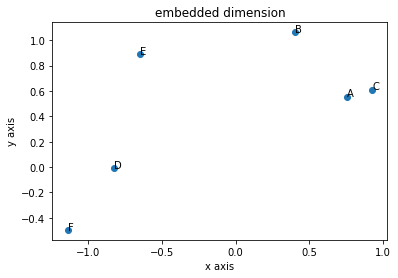

In [34]:
adj_list = [['B','C'], ['A','C','E'], ['A', 'B'], ['A', 'E', 'F'], ['B', 'D'], ['D']]
'''
                A.           B.            C.             D.             E.      F.

'''
size_vertex = len(adj_list)  # number of vertices

order_index = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

import torch
import torch.nn as nn
import random
import matplotlib as plt


w=3            # window size
d=2            # embedding size
y=200          # walks per vertex
t=5            # walk length
lr=0.025       # learning rate

v=['A','B','C','D','E','F'] #labels of available vertices


def RandomWalk(node, t):
    walk = [node]  # Walk starts from this node
    for i in range(t - 1):
        node = adj_list[order_index[node]][random.randint(0, len(adj_list[order_index[node]]) - 1)]
        walk.append(node)

    return walk


class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.phi = nn.Parameter(torch.rand((size_vertex, d), requires_grad=True))
        self.phi2 = nn.Parameter(torch.rand((d, size_vertex), requires_grad=True))
        #phi -> d차원에 기존 그래프들 embedding
        #phi2-> embedding한 거 원래 차원으로 복원
    def forward(self, one_hot):
        hidden = torch.matmul(one_hot, self.phi)
        out = torch.matmul(hidden, self.phi2)
        return out



model = Model()


def skip_gram(wvi, w):
    for j in range(len(wvi)):
        for k in range(max(0, j - w), min(j + w, len(wvi))):

            # generate one hot vector
            one_hot = torch.zeros(size_vertex)
            one_hot[order_index[wvi[j]]] = 1

            out = model(one_hot)
            loss = torch.log(torch.sum(torch.exp(out))) - out[order_index[wvi[k]]]
            loss.backward()

            for param in model.parameters():
                param.data.sub_(lr * param.grad)
                param.grad.data.zero_()



for i in range(y):
    random.shuffle(v)
    for vi in v:
        wvi=RandomWalk(vi,t)
        skip_gram(wvi, w)


with torch.no_grad():
  k = model.phi
  print(k)
  k = k.tolist()
  x = []
  y = []
  for i in k:
    x.append(i[0])
    y.append(i[1])
  plt.pyplot.scatter(x,y)
  plt.pyplot.xlabel('x axis')
  plt.pyplot.ylabel('y axis')
  plt.pyplot.title('embedded dimension')
  v=['A','B','C','D','E','F']
  for i in range(6):
    plt.pyplot.text(x[i], y[i], v[i])

  plt.pyplot.show()  

embedded된 그래프를 보면 A,B,C가 상대적으로 인접하여 있고, D,E,F가 상대적으로 인접한 것을 확인할 수 있다. 본래 그래프의 모양을 잘 보존한 것으로 보여진다. 